In [35]:
import numpy as np
import pandas as pd
import random
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
#Import all the processed datasets into one notebook
#Enigma housing price dataset
data = pd.read_csv('processed_dataset.csv')
data.zipcode = data.zipcode.astype(int)

#Foursquare dataset
additional_features = pd.read_csv('Features.csv')

#Merge them on zipcode attribute
data_merged = pd.merge(data, additional_features, how = 'left', left_on='zipcode', right_on='zipcode')

In [98]:
#Taxi dataset
data_taxi = pd.read_csv('taxi.csv')
data_taxi.drop('Unnamed: 0', axis = 1, inplace = True)
#merge them on zipcode attribute
data_merged_2 = pd.merge(data_merged, data_taxi, how = 'left', on = 'zipcode')

In [117]:
#See the structure
data_merged_2.head()

,Unnamed: 0,sale_price,building_class_category_code,tax_class_at_present_code,building_class_at_present_code,zipcode,residential_units,commercial_units,land_square_feet,gross_square_feet,...,VIOLATION,density,houseofunits,landarea,pop,totwage,water_area,wealthy,vals_x,vals_y
0,0,3750000.0,0,0,0,10009,11.0,0.0,1750.000000,6500.000000,...,517.0,98946.774194,31709.0,0.62,61347.0,1.572037e+09,0.0,25625.324955,20563.0,10009.0
1,1,5235000.0,0,0,1,10009,24.0,1.0,2650.000000,9960.000000,...,517.0,98946.774194,31709.0,0.62,61347.0,1.572037e+09,0.0,25625.324955,20563.0,10009.0
2,2,6625000.0,0,1,2,10009,5.0,0.0,1633.000000,6440.000000,...,517.0,98946.774194,31709.0,0.62,61347.0,1.572037e+09,0.0,25625.324955,20563.0,10009.0
3,3,7675000.0,0,0,1,10009,11.0,1.0,2388.000000,8045.000000,...,517.0,98946.774194,31709.0,0.62,61347.0,1.572037e+09,0.0,25625.324955,20563.0,10009.0
4,4,499000.0,1,0,3,10009,0.0,0.0,4066.901863,3778.696053,...,517.0,98946.774194,31709.0,0.62,61347.0,1.572037e+09,0.0,25625.324955,20563.0,10009.0


In [118]:
cols = list(set(additional_features.columns)) + list(set(data_taxi.columns))

In [119]:
for i in cols:
    data_mean = data_merged_2[i].mean()
    data_merged_2[i] = data_merged_2[i].fillna(data_mean)

In [120]:
#Print the correlation matrix
def drawheatmap(df):
    '''Builds the heat map for the given data'''
    f, ax = plt.subplots(figsize=(20, 20))
    sns.heatmap(df.corr(method='spearman'), annot=False, cmap='coolwarm_r')

In [137]:
data_merged_2.drop('Unnamed: 0', axis=1, inplace = True)

In [138]:
data_merged_2.drop(['pop','zipcode'], axis = 1, inplace = True)

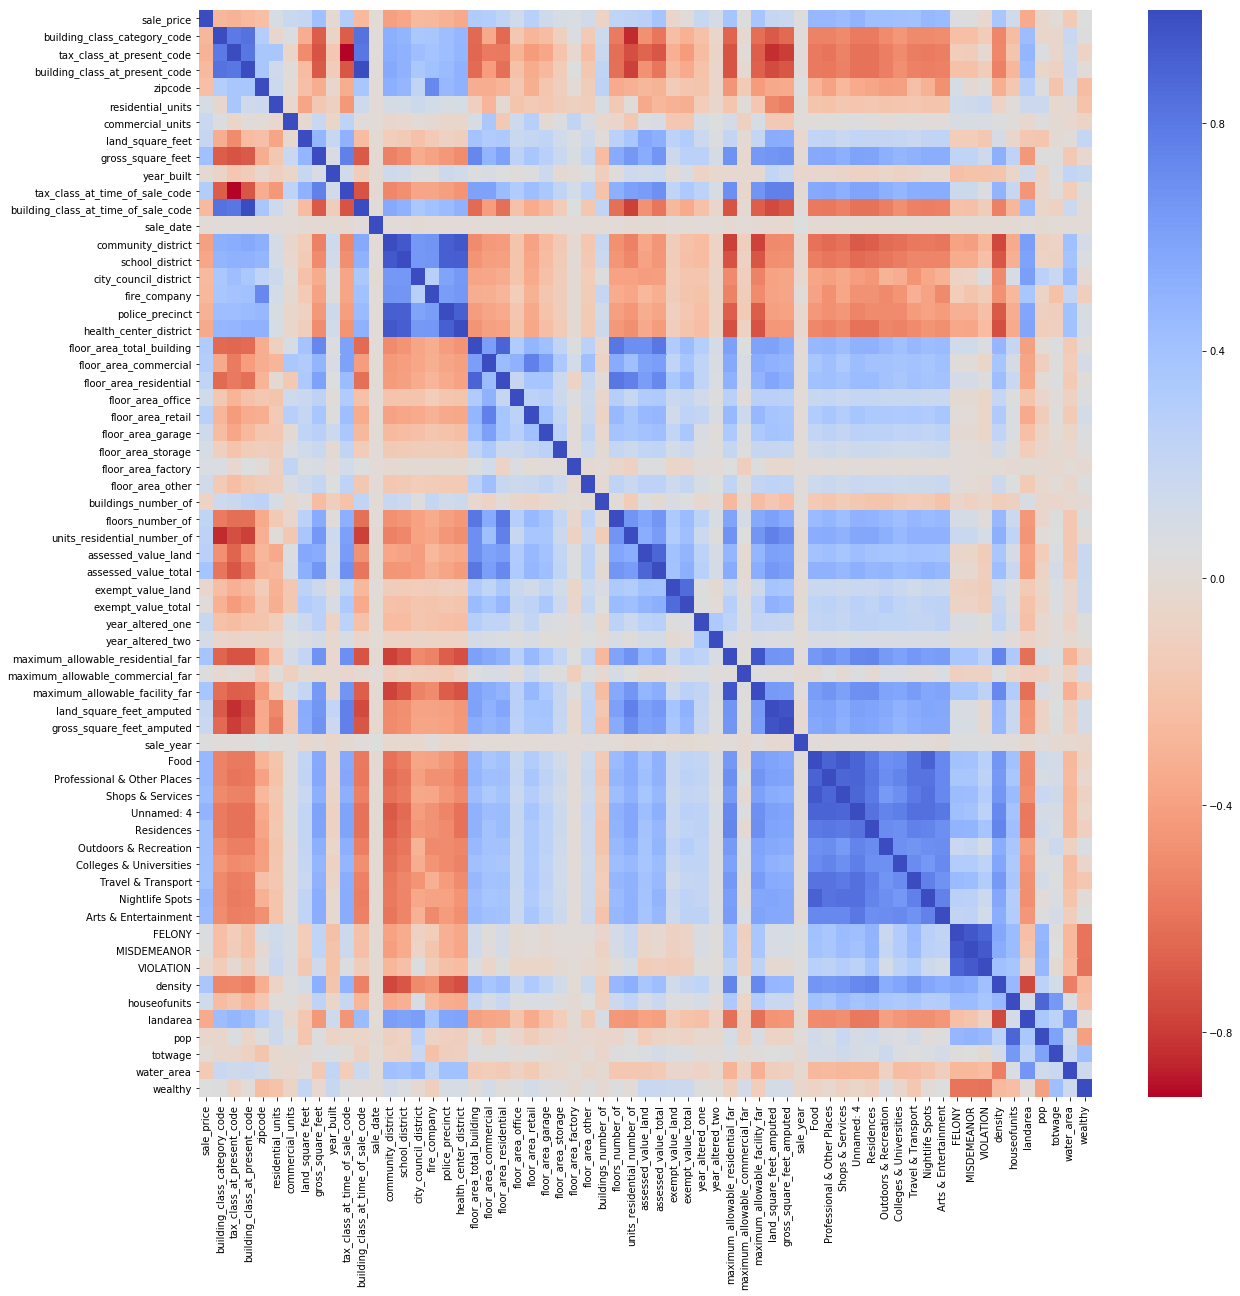

In [139]:
drawheatmap(data_merged)

In [140]:
#SPlit the data into train and test sets
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_merged, train_size=0.8, random_state=5)

In [141]:
#Split the data into train and valiodation sets
train, val =  train_test_split(train, train_size = 0.75, random_state = 5)

In [142]:
from sklearn.ensemble import RandomForestRegressor

In [168]:
X_train, y_train = train.iloc[:,1:], train.iloc[:,0]
X_val, y_val = val.iloc[:,1:], val.iloc[:,0]

In [175]:
#Build the random forest model with different leaf and split configuration
leafs = np.logspace(1,2.2,num = 10)
split = np.logspace(1,3,num = 10)
best_r_sq = 0
train_r_sq = []
val_r_sq = []
for i in leafs:
    for j in split:
        clf = RandomForestRegressor(min_samples_leaf= int(i), min_samples_split= int(j))
        clf.fit(X_train, y_train)
        val_score = clf.score(X_val, y_val)
        val_r_sq.append(val_score)
        train_r_sq.append(clf.score(X_train, y_train))
        if best_r_sq < val_score:
            best_r_sq = val_score
            best_leaf = i
            best_split = j

In [176]:
best_r_sq

0.34943612710449001

In [180]:
best_leaf

18.478497974222908

In [181]:
best_split

16.681005372000591

In [185]:
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [186]:
imp = clf.feature_importances_

In [187]:
#Print the feature importance to see what influences the price of a house in NYC
def plotfeatureimportances(train, importance):
    '''Plots feature importance in a sorted order and shows the most significant variables at the top'''
    X = list(train.columns)
    feature_importance_df = pd.DataFrame(data = importance, index = X, columns=['coefficient_values'])
    feature_importance_df['sort'] = feature_importance_df.coefficient_values.abs()
    sorted_feature_imp_df = feature_importance_df.sort_values(by='sort', ascending=False).drop('sort', axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 15)
    sns.barplot(np.array(sorted_feature_imp_df.coefficient_values), np.array(sorted_feature_imp_df.index.values))
    plt.title('Feature Importances')
    plt.xlabel('Coefficients')
    plt.ylabel('Feature Names')
    drawheatmap(data_merged_2)

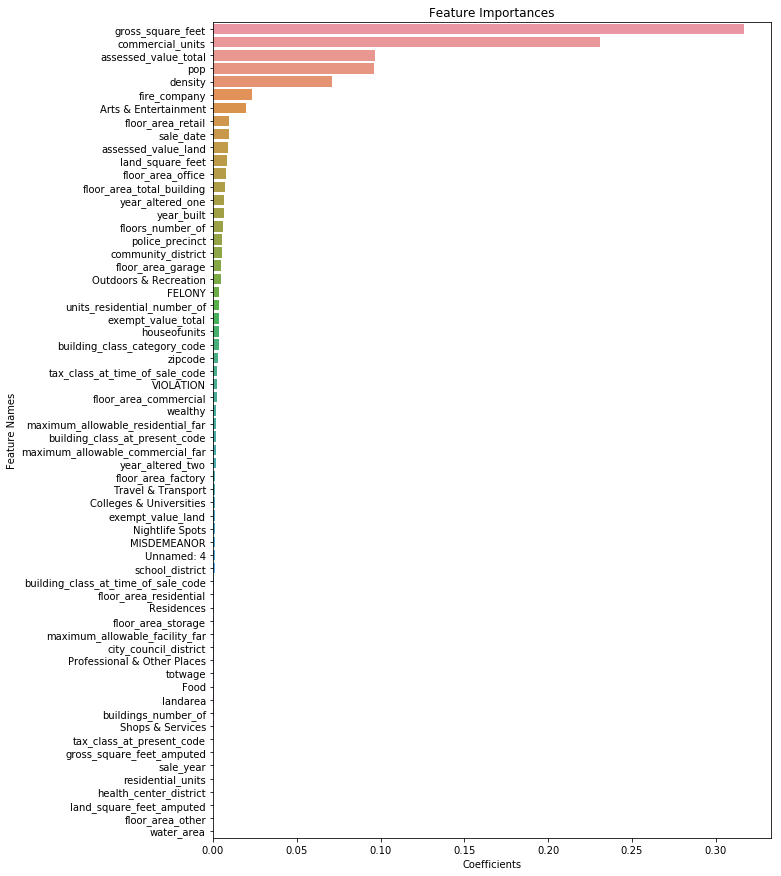

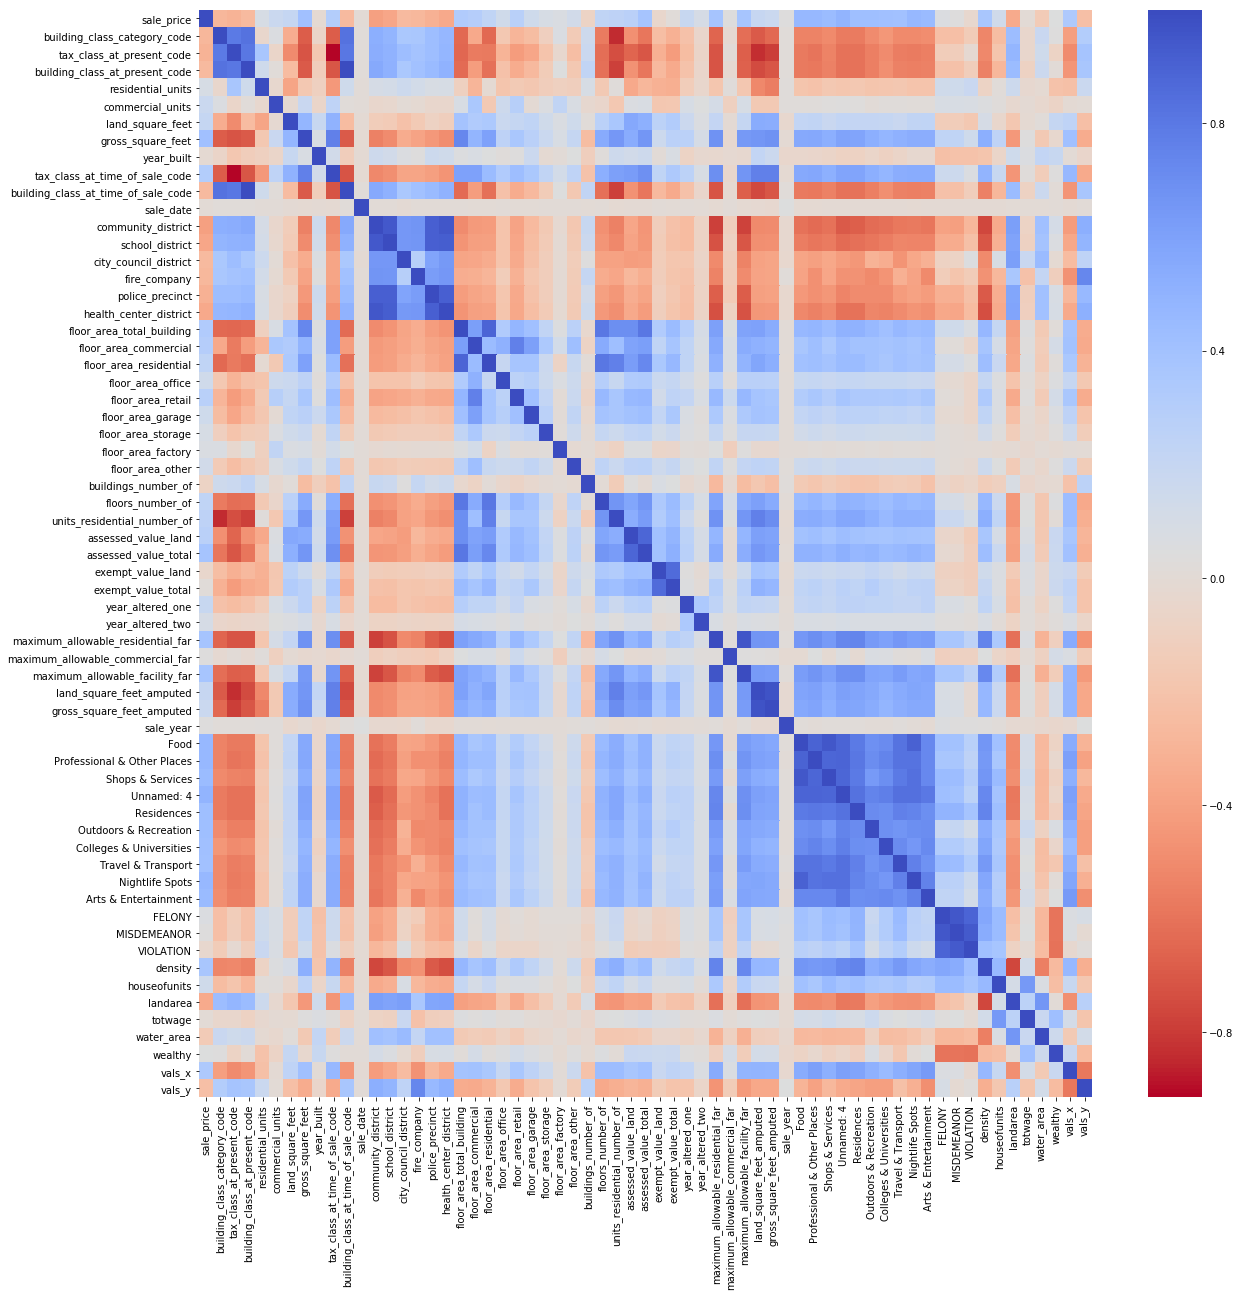

In [188]:
plotfeatureimportances(X_train, imp)